# <span style="color:red">Análisis de datos en Python</span>


---
> ---
> Adrián Felipe Hernández Borda
>
> ---
>
> Universidad Pedagógica y Tecnológica de Colombia $\Big[\text{UPTC}\Big]$
>
> Universidad Aurónoma de Sinaloa $\Big[\text{UAS}\Big]$
>
> ---


---



El presente es un cuaderno de trabajo  y pruebas sobre el proyecto desarrollado en la **optativa de análisis de datos en python**
## <span style="color:rgb(0,180,200)">Objetivos</span>

Predecir las calificaciones (***Promedio / Matemática, Escritura y Lectura***)  de estudiantes con base a algunas características de su entorno y vida personal

---
## <span style="color:rgb(180,200,0)">Importar librerías</span>

---


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn as sk
sns.set_style(style="ticks")
from os import cpu_count as ncpu
from multiprocessing import Pool as pool
from fitter import Fitter as ftr

---
## <span style="color:rgb(180,200,0)">Importar datos</span>

---
Usando variables de cadenas de caracteres que contienen la ruta del conjunto de datos se importa el csv.

In [2]:
path = "./datasets/"
#file = "global-data-on-sustainable-energy.csv"
file = "Expanded_data_with_more_features.csv"
#file_exp = "Original_data_with_more_rows.csv"
full_path = path+file
#full_path_exp = path+file_exp
print(f"Dirección del conjunto de datos: '{full_path:s}'")


Dirección del conjunto de datos: './datasets/Expanded_data_with_more_features.csv'


In [20]:
data = pd.read_csv(full_path,sep=",")
sz = data.shape
print(f"Número de variables -> {sz[0]}\nEntradas del conjunto de datos -> {sz[1]}")

print("\n--- CABECERA DEL CONJUNTO DE DATOS ---\n")
display(data.head())

#print("\n--- DESCRIPCIÓN ---\n")
#data_exp = pd.read_csv(full_path_exp,sep=",")

Número de variables -> 30641
Entradas del conjunto de datos -> 15

--- CABECERA DEL CONJUNTO DE DATOS ---



,ID,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,ParentMaritalStatus,PracticeSport,IsFirstChild,NrSiblings,TransportMeans,WklyStudyHours,MathScore,ReadingScore,WritingScore
0,0,female,NaN,bachelor's degree,standard,none,married,regularly,yes,3.0,school_bus,< 5,71,71,74
1,1,female,group C,some college,standard,NaN,married,sometimes,yes,0.0,NaN,5 - 10,69,90,88
2,2,female,group B,master's degree,standard,none,single,sometimes,yes,4.0,school_bus,< 5,87,93,91
3,3,male,group A,associate's degree,free/reduced,none,married,never,no,1.0,NaN,5 - 10,45,56,42
4,4,male,group C,some college,standard,none,married,sometimes,yes,0.0,school_bus,5 - 10,76,78,75


---
# <span style="color:rgb(180,200,0)">Descripción del conjunto de datos</span>

---

## Variables 
### Categóricas
1. `Gender`
2. `EthnicGroup` 
3. `ParentMaritalStatus`
4. `PracticeSport`
5. `IsFirstChild`
6. `TransportMeans`


### Ordinales
1. `LunchType` **Basado en que la merienda da energía que consume el cerebro**
2. `TestPrep`
3. `ParentEduc` **Basado en el grado de escolaridad**
4. `WklyStudyHours` **Son intervalos de tiempo, no es un número de punto flotante**

### Cuantitativas (Discretas)
1. `ID` **No aporta información para el análisis del conjunto de datos**
2. `NrSiblings`
3. `MathScore`
4. `ReadingScore`
5. `WritingScore` 

---
# <span style="color:rgb(180,200,0)">Reescritura del conjunto de datos</span>

---
Ahora el propósito es asignar a cada valor de una variable categórica un número entero, primero se crea unas funciones que permitan reemplazar los datos de un dataset por números. 

In [4]:
# Función que reemplaza los valores  de acuerdo a como aparezcan al leer de arriba abajo el conjunto de datos

def replace_values(df:pd.DataFrame):
    values = list(pd.get_dummies(df,prefix='',prefix_sep='').columns.values)
    print(values)
    new_values = [k+1 for k in range(len(values)) ]
    dic = dict(map(lambda x,y:(x,y),values,new_values))
    df = df.replace(to_replace=dic)
    print(f"{df.keys()[0]} -> {dic}")
    return df

# Función que reemplaza una columna de un conjunto de datos

def replace_col(df_main:pd.DataFrame,df_col:pd.DataFrame):
    df_main = df_main.drop(labels=df_col.keys()[0],axis=1)
    df_main = pd.concat([df_main,df_col],axis=1)
    return df_main

Ahora se puede seleccionar las columnas de las variables categóricas  de acuerdo a la inspección previa. Posteriormente el conjunto de datos se puede separar en tres conjuntos más sencillos a los que se aplicará las funciones definidas.

In [5]:
categoric_cols = ["Gender","EthnicGroup","ParentMaritalStatus","PracticeSport","IsFirstChild","TransportMeans"]
ordinal_cols = ["LunchType","TestPrep","ParentEduc","WklyStudyHours"]
cuantitative_cols = ["ID","NrSiblings","MathScore","ReadingScore","WritingScore"]

data_ordinal = data[ordinal_cols]
data_categoric = data[categoric_cols]
data_cuantitative = data[cuantitative_cols]

Una forma de asignar valores numéricos para las variables categóricas es el siguiente ya que:
> No distingue jerarquía para los ordinales

In [6]:
for cols in categoric_cols:
    data_categoric = replace_col( data_categoric,replace_values(data_categoric[[cols]]) )
display(data_categoric)

data_ordinal = replace_col(data_ordinal,data_ordinal[["LunchType"]].replace(to_replace={'standard': 2, 'free/reduced': 1}))
data_ordinal = replace_col(data_ordinal,data_ordinal[["WklyStudyHours"]].replace(to_replace={'< 5': 1, '5 - 10': 2, '> 10': 3}))
data_ordinal = replace_col(data_ordinal,data_ordinal[["ParentEduc"]].replace(to_replace={"bachelor's degree": 4, 'some college': 3, "master's degree": 6, "associate's degree": 5, 'high school': 2, 'some high school': 1}))
data_ordinal = replace_col(data_ordinal,data_ordinal[["TestPrep"]].replace(to_replace={'none': 1, 'completed': 2}))

['female', 'male']
Gender -> {'female': 1, 'male': 2}
['group A', 'group B', 'group C', 'group D', 'group E']
EthnicGroup -> {'group A': 1, 'group B': 2, 'group C': 3, 'group D': 4, 'group E': 5}
['divorced', 'married', 'single', 'widowed']
ParentMaritalStatus -> {'divorced': 1, 'married': 2, 'single': 3, 'widowed': 4}
['never', 'regularly', 'sometimes']
PracticeSport -> {'never': 1, 'regularly': 2, 'sometimes': 3}
['no', 'yes']
IsFirstChild -> {'no': 1, 'yes': 2}
['private', 'school_bus']
TransportMeans -> {'private': 1, 'school_bus': 2}


,Gender,EthnicGroup,ParentMaritalStatus,PracticeSport,IsFirstChild,TransportMeans
0,1,NaN,2.0,2.0,2.0,2.0
1,1,3.0,2.0,3.0,2.0,NaN
2,1,2.0,3.0,3.0,2.0,2.0
3,2,1.0,2.0,1.0,1.0,NaN
4,2,3.0,2.0,3.0,2.0,2.0
...,...,...,...,...,...,...
30636,1,4.0,3.0,3.0,1.0,2.0
30637,2,5.0,3.0,2.0,1.0,1.0
30638,1,NaN,2.0,3.0,1.0,1.0
30639,1,4.0,2.0,2.0,1.0,2.0


Las variables ordinales toman valores que se mapearon a valores numéricos con base en el algoritmo de identifiación de resultados como sigue

In [7]:
data_new = pd.concat([data_cuantitative,data_ordinal,data_categoric],axis=1)

print("--- CONJUNTO DE DATOS NUMÉRICO ---")
      
display(data_new.head())
data_new.to_csv(path_or_buf="./data_num_new.csv",sep=",")

--- CONJUNTO DE DATOS NUMÉRICO ---


,ID,NrSiblings,MathScore,ReadingScore,WritingScore,LunchType,WklyStudyHours,ParentEduc,TestPrep,Gender,EthnicGroup,ParentMaritalStatus,PracticeSport,IsFirstChild,TransportMeans
0,0,3.0,71,71,74,2,1.0,4.0,1.0,1,NaN,2.0,2.0,2.0,2.0
1,1,0.0,69,90,88,2,2.0,3.0,NaN,1,3.0,2.0,3.0,2.0,NaN
2,2,4.0,87,93,91,2,1.0,6.0,1.0,1,2.0,3.0,3.0,2.0,2.0
3,3,1.0,45,56,42,1,2.0,5.0,1.0,2,1.0,2.0,1.0,1.0,NaN
4,4,0.0,76,78,75,2,2.0,3.0,1.0,2,3.0,2.0,3.0,2.0,2.0


In [8]:
for df in data_new.columns.values:
    data_new[[df]] = data_new[[df]].fillna(value=round(np.mean(data_new[df])))

In [9]:
data_new.to_csv(path_or_buf="./data_new_no_nan.csv",sep=',')
data_new=[]
data = []

---

# <span style="color:rgb(180,200,0)">Intento de normalizar las distribuciones</span>

---



Ahora se busca mapear cada entrada $x$ de cada variable del dataframe a un número $x'$ entre el intervalo $[0,1]$ de manera que
$$\max(x)=\chi\to1,\qquad \min(x)=\beta\to0$$
siendo $x$  un elemento de una columna del data frame, incluyendo el máximo y el mínimo se debe satisfacer que:

$$\min(x)-\beta=0=\min(x')$$
$$\dfrac{\max(x)-\beta}{\chi-\beta}=1=\max(x')$$

de manera que en general se tiene

$$x'=\dfrac{x-\beta}{\chi-\beta}$$

aplicando ese mapeo se obtiene:

In [19]:
data = pd.read_csv("data_new_no_nan.csv")
data_ordinal = data[ordinal_cols]
data_categoric = data[categoric_cols]
data_cuantitative = data[cuantitative_cols]
display(data.head())

,Unnamed: 0,ID,NrSiblings,MathScore,ReadingScore,WritingScore,LunchType,WklyStudyHours,ParentEduc,TestPrep,Gender,EthnicGroup,ParentMaritalStatus,PracticeSport,IsFirstChild,TransportMeans
0,0,0,3.0,71,71,74,2,1.0,4.0,1.0,1,3.0,2.0,2.0,2.0,2.0
1,1,1,0.0,69,90,88,2,2.0,3.0,1.0,1,3.0,2.0,3.0,2.0,2.0
2,2,2,4.0,87,93,91,2,1.0,6.0,1.0,1,2.0,3.0,3.0,2.0,2.0
3,3,3,1.0,45,56,42,1,2.0,5.0,1.0,2,1.0,2.0,1.0,1.0,2.0
4,4,4,0.0,76,78,75,2,2.0,3.0,1.0,2,3.0,2.0,3.0,2.0,2.0


Como las primera columna resultó de guardar el dataframe a un archivo nuevo, es decir que se asigna un identificador ascendente a cada valor del dataframe, se puede suprimir. 

In [11]:
data = data.iloc[:,1:]

display(data.describe())

,ID,NrSiblings,MathScore,ReadingScore,WritingScore,LunchType,WklyStudyHours,ParentEduc,TestPrep,Gender,EthnicGroup,ParentMaritalStatus,PracticeSport,IsFirstChild,TransportMeans
count,30641.000000,30641.000000,30641.000000,30641.000000,30641.000000,30641.000000,30641.000000,30641.000000,30641.000000,30641.000000,30641.000000,30641.000000,30641.000000,30641.000000,30641.00000
mean,499.556607,2.138409,66.558402,69.377533,68.418622,1.649620,1.900917,3.125126,1.324891,1.496622,3.173656,2.109657,2.365817,1.652263,1.62919
std,288.747894,1.420707,15.361616,14.758952,15.443525,0.477097,0.654847,1.522977,0.468342,0.499997,1.105484,0.676237,0.702396,0.476260,0.48303
min,0.000000,0.000000,0.000000,10.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000
25%,249.000000,1.000000,56.000000,59.000000,58.000000,1.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,2.000000,1.000000,1.00000
50%,500.000000,2.000000,67.000000,70.000000,69.000000,2.000000,2.000000,3.000000,1.000000,1.000000,3.000000,2.000000,2.000000,2.000000,2.00000
75%,750.000000,3.000000,78.000000,80.000000,79.000000,2.000000,2.000000,4.000000,2.000000,2.000000,4.000000,3.000000,3.000000,2.000000,2.00000
max,999.000000,7.000000,100.000000,100.000000,100.000000,2.000000,3.000000,6.000000,2.000000,2.000000,5.000000,4.000000,3.000000,2.000000,2.00000


In [12]:
data_norm = pd.concat([(data.iloc[:,k]-min(data.iloc[:,k]))/(max(data.iloc[:,k])-min(data.iloc[:,k])) for k in range(data.shape[1])],axis=1)
display(data_norm.describe())

,ID,NrSiblings,MathScore,ReadingScore,WritingScore,LunchType,WklyStudyHours,ParentEduc,TestPrep,Gender,EthnicGroup,ParentMaritalStatus,PracticeSport,IsFirstChild,TransportMeans
count,30641.000000,30641.000000,30641.000000,30641.000000,30641.000000,30641.000000,30641.000000,30641.000000,30641.000000,30641.000000,30641.000000,30641.000000,30641.000000,30641.000000,30641.00000
mean,0.500057,0.305487,0.665584,0.659750,0.671027,0.649620,0.450459,0.425025,0.324891,0.496622,0.543414,0.369886,0.682909,0.652263,0.62919
std,0.289037,0.202958,0.153616,0.163988,0.160870,0.477097,0.327423,0.304595,0.468342,0.499997,0.276371,0.225412,0.351198,0.476260,0.48303
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.249249,0.142857,0.560000,0.544444,0.562500,0.000000,0.000000,0.200000,0.000000,0.000000,0.250000,0.333333,0.500000,0.000000,0.00000
50%,0.500501,0.285714,0.670000,0.666667,0.677083,1.000000,0.500000,0.400000,0.000000,0.000000,0.500000,0.333333,0.500000,1.000000,1.00000
75%,0.750751,0.428571,0.780000,0.777778,0.781250,1.000000,0.500000,0.600000,1.000000,1.000000,0.750000,0.666667,1.000000,1.000000,1.00000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [13]:
def corr_matrix (df:pd.DataFrame):
    corr = df.corr()
    sns.heatmap(data=corr,annot=False,cbar=True,cmap="RdYlGn")

None

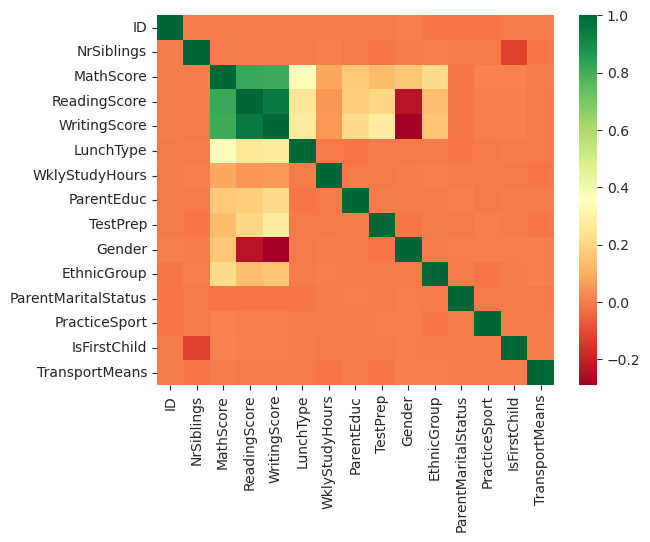

In [14]:
display(corr_matrix(data))

None

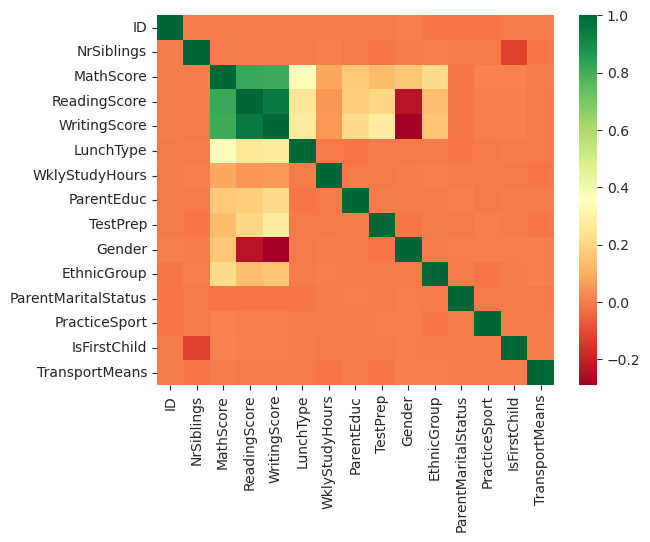

In [15]:
display(corr_matrix(data_norm))

In [16]:
bins = int(1 + np.log2(sz[0]) ) # Regla de Sturges
print(f"la cantidad de barras es {bins:3d}")
fntsz = 10

la cantidad de barras es  15


In [17]:
dist = data["ParentEduc","WklyStudyHours"]
dist_hist,dist_dom = np.histogram(dist,bins=10*bins)
dist_hist += 1
dist_hist = dist_hist/max(dist_hist)
dist_dom = dist_dom[1:]
eps = 0
weigths = 1/(( (max(dist_dom)-min(dist_dom)) * dist_hist) + eps )


KeyError: ('ParentEduc', 'WklyStudyHours')

In [ ]:
#plt.hist(dist,bins=bins,label="histogram")
plt.plot(dist_dom,dist_hist,"-",label="distribution")
#plt.plot(dist_dom,weigths,"-",label="weigths")
plt.plot(dist_dom,dist_hist*weigths,"--",label="normalized distribution")
plt.legend(fontsize=fntsz)
plt.show()


In [ ]:
def normalizer (df:pd.DataFrame):
    dist = np.histogram(df,bins=bins)
    weights = 1./(())

La distribución entre asignaturas es similar, luego vale al pena pensar en un promedio entre las 3 asignaturas. Otra manera de visualizarlo es encontrando dicho promedio y viendo la correlación entre los datos de las materias y el promedio.

> Descripción de las distribuciones de notas por distribuciones estadísticas.

Ahora la idea es comparar los parámetros de distribución de las calificaciones para evaluar si conviene escribirlas como en promedio de las 3 o separadas. al criterio es, si los parámetros son parecidos, entonces vale la pena describirlas como una sola, en otro acso no.

### Fit de las distribuciones de notas a distribuciones estadisticas
Con `Fitter` se evaluará cuál distribución estadística es la que mejor ajusta y sobre ella se evaluará los datos.

Para optimizar tiempo usaré `multiprocessing.Pool`

In [ ]:
def fits(df:pd.DataFrame):
    f_df = ftr(df,distributions=["gamma"])
    f_df.fit()
    return f_df

In [ ]:
dfs = [data_cuantitative[["MathScore"]],data_cuantitative[["WritingScore"]],data_cuantitative[["WritingScore"]]]

with pool(ncpu()) as p:
    fit_info = p.map(fits,dfs)


In [ ]:
fit_info[0].fit()

In [ ]:
fit_info[0].summary()

In [ ]:
def corr_matrix (df:pd.DataFrame):
    corr = df.corr()
    sns.heatmap(data=corr,annot=False,cbar=True,cmap="RdYlGn")
corr_matrix(data)
corr_matrix(data_new)

## Variables más relevantes
1. `LunchType`
2. `TestPrep`
3. `ParentEduc`

## Variables menos relevantes
1. `ID`
2. `NrSiblings`
3. `ẀklyStudyHours`


In [ ]:
sns.pairplot(data=data_norm)

In [ ]:
sns.pairplot(data=data)

## Análisis de variables con Scikit-Learn

### importar los módulos de selección

se usará la métrica de $\chi^{2}$, Fisher

In [ ]:
from sklearn.feature_selection import chi2, SelectKBest, f_classif

In [ ]:

'''predict_var = data_new[["MeanScore"]].fillna(np.mean(data_new[["MeanScore"]]))

for col in list(data_new.columns.values):
    data_new = data_new[[col]].fillna(np.mean(data_new[[col]]))
train_set = data_new.drop(labels="MeanScore",axis=1)
n_atrib = 3 
cols = list(data_new.columns.values)

best_vars = SelectKBest(f_classif,k=n_atrib).fit(train_set,predict_var)
'''

In [ ]:
## Dont forget

print(pd.get_dummies(data[["ParentEduc"]],prefix='',prefix_sep='').columns.values)